In [32]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
#https://python-future.org/quickstart.html

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt, numpy as np
import matplotlib.colors as mcolors
import hera_cal, hera_qm, hera_sim
import linsolve
import scipy
import os
import platform

from matplotlib import gridspec
from pyuvdata import UVData
from datetime import datetime
from IPython.display import Markdown
from hera_cal import io, redcal, abscal, utils, apply_cal
from hera_cal.datacontainer import DataContainer
from copy import deepcopy
from hera_cal.utils import split_pol, split_bl
from importlib import import_module

In [12]:
path = "/Users/tashaleebillings/Desktop/data/2.2Validation/"
model_file =os.path.join(path,'zen.2458106.27878.uvh5.uvfits')

In [16]:
uv_model = UVData()
uv_model.read(model_file)

Telescope mock-HERA is not in known_telescopes.


In [40]:
casaants=np.unique(uv_model.ant_1_array)
casafreqs=np.unique(uv_model.freq_array)

In [21]:
uncal_file="/Users/tashaleebillings/Desktop/data/2.2Validation/uncalibrated_zen.2458106.27878.uvh5"
uv_uncal = UVData()
uv_uncal.read(uncal_file)
uv_uncal.write_uvfits("/Users/tashaleebillings/Desktop/data/insertmodel/uncalibrated_zen.2458106.27878.uvfits",
                      spoof_nonessential=True,force_phase=True)

Telescope mock-HERA is not in known_telescopes.


The data are in drift mode and do not have a defined phase center. Phasing to zenith of the first timestamp.


In [33]:
%%time
path_ = '/Users/tashaleebillings/Desktop/data/2.2Validation/'
rimez_sim = 'zen.2458106.27878.uvh5'
hd = io.HERAData(path_+rimez_sim)
data, flags, nsamples = hd.read()
ants = sorted({ant: 0 for bl in data.keys() for ant in split_bl(bl)}.keys())

CPU times: user 18.7 s, sys: 12.8 s, total: 31.5 s
Wall time: 35.6 s


In [35]:
%%time
dly_rng=(-20, 20)

# generate gains with a realistic bandpass and delays between -20 and 20 ns
gen_bandpass = hera_sim.sigchain.gen_bandpass(fqs=hd.freqs/1e9, ants=ants, gain_spread=0.1)
# Correct phase of ref ant 0. I am setting phase to zero for the ref ant that I chose.
rmantphs_gen_bandpass = {}
for i,ant in enumerate(ants):
    if i in np.arange(0,37*2,2):
        rmantphs_gen_bandpass[ant] = gen_bandpass[ant]*gen_bandpass[(0, 'Jxx')].conj()
    else:
        rmantphs_gen_bandpass[ant] = gen_bandpass[ant]*gen_bandpass[(0, 'Jyy')].conj()
#print(rmantphs_gen_bandpass)

# Correct phase of ref ant#0. I am setting phase to zero for the ref ant that I chose.
gen_delay_phs = hera_sim.sigchain.gen_delay_phs(fqs=hd.freqs/1e9, ants=ants, dly_rng=dly_rng)
rmantphs_gen_delay_phs = {}
for i,ant in enumerate(ants):
    if i in np.arange(0,37*2,2):
        rmantphs_gen_delay_phs[ant] = gen_delay_phs[ant]*gen_delay_phs[(0, 'Jxx')].conj()
    else:
        rmantphs_gen_delay_phs[ant] = gen_delay_phs[ant]*gen_delay_phs[(0, 'Jyy')].conj()
#print(rmantphs_gen_delay_phs)

#gen_gains = {ai: gen_bandpass[ai] * gen_delay_phs[ai] for ai in ants}
rmantphs_gen_gains = {ai: rmantphs_gen_bandpass[ai] * rmantphs_gen_delay_phs[ai] for ai in ants}

#true_gains = gen_gains
rmantphs_true_gains = rmantphs_gen_gains # adusting reference antenna & others phase

# add random phase offsets to each antenna's gain
phase_offsets = {ant: 2 * np.pi * np.random.rand() for ant in rmantphs_true_gains.keys()}
rmantphs_phase_offsets = {}
for i,ant in enumerate(ants):
    if i in np.arange(0,37*2,2):
        rmantphs_phase_offsets[ant] = phase_offsets[ant] - phase_offsets[(0, 'Jxx')]
    else:
        rmantphs_phase_offsets[ant] = phase_offsets[ant] - phase_offsets[(0, 'Jyy')]

# uncalibratate data and save
#true_gains = {ant: g * np.ones((hd.Ntimes, hd.Nfreqs)) * np.exp(1.0j * phase_offsets[ant])
#              for ant, g in true_gains.items()}
rmantphs_true_gains = {ant: g * np.ones((hd.Ntimes, hd.Nfreqs)) * np.exp(1.0j * rmantphs_phase_offsets[ant])
              for ant, g in rmantphs_true_gains.items()}

CPU times: user 71.8 ms, sys: 35.8 ms, total: 108 ms
Wall time: 108 ms


In [ ]:
cparamB = glob.glob("*.B.cal")
cparamGphs = glob.glob("*.Gphs.cal")
cparamGamp = glob.glob("*.Gamp.cal")
fparamK = glob.glob("*.K.cal")

for c in cparamB:
    tb.open(c)
    gain = tb.getcol('CPARAM')
    np.savez(c+'.npz',bp=gain)
    print("Created "+ c+'.npz')

for c in cparamGphs:
    tb.open(c)
    gain = tb.getcol('CPARAM')
    np.savez(c+'.npz',phases=gain)
    print("Created "+ c+'.npz')
    
for c in cparamGamp:
    tb.open(c)
    gain = tb.getcol('CPARAM')
    np.savez(c+'.npz',amp=gain)
    print("Created "+ c+'.npz')

for f in fparamK:
    tb.open(f)
    gain = tb.getcol('FPARAM')
    np.savez(f+'.npz',delays=gain)
    print("Created "+ f+'.npz')

In [45]:
#tb.open("uncalibrated_zen.2458106.27878.uvh5.MS")
#casaants=np.unique(np.sort(tb.getcol('ANTENNA1')))
#casafreqs=tb.getcol('CHAN_FREQ')[:,0]
npz_path = "/Users/tashaleebillings/Desktop/data/insertmodel/"
bp = np.load(npz_path+"uncalibrated_zen.2458106.27878.uvh5.MS.B.cal.npz")
casa_delay = np.zeros_like(bp['bp'])
comb_phase = np.zeros_like(bp['bp'])

kc = npz_path+"uncalibrated_zen.2458106.27878.uvh5.MS.K.cal.npz"
delay = np.load(kc)["delays"]

gcphs = npz_path+"uncalibrated_zen.2458106.27878.uvh5.MS.Gphs.cal.npz"
offset = np.load(gcphs)['phases']

for ant in casaants:
    casa_delay[0,:,ant] = np.exp(2j * np.pi * delay[0,0,ant]*1e-9 * casafreqs)
    comb_phase[0,:,ant] = bp['bp'][0,:,ant].conj()*casa_delay[0,:,ant].conj()*offset[0,0,ant]

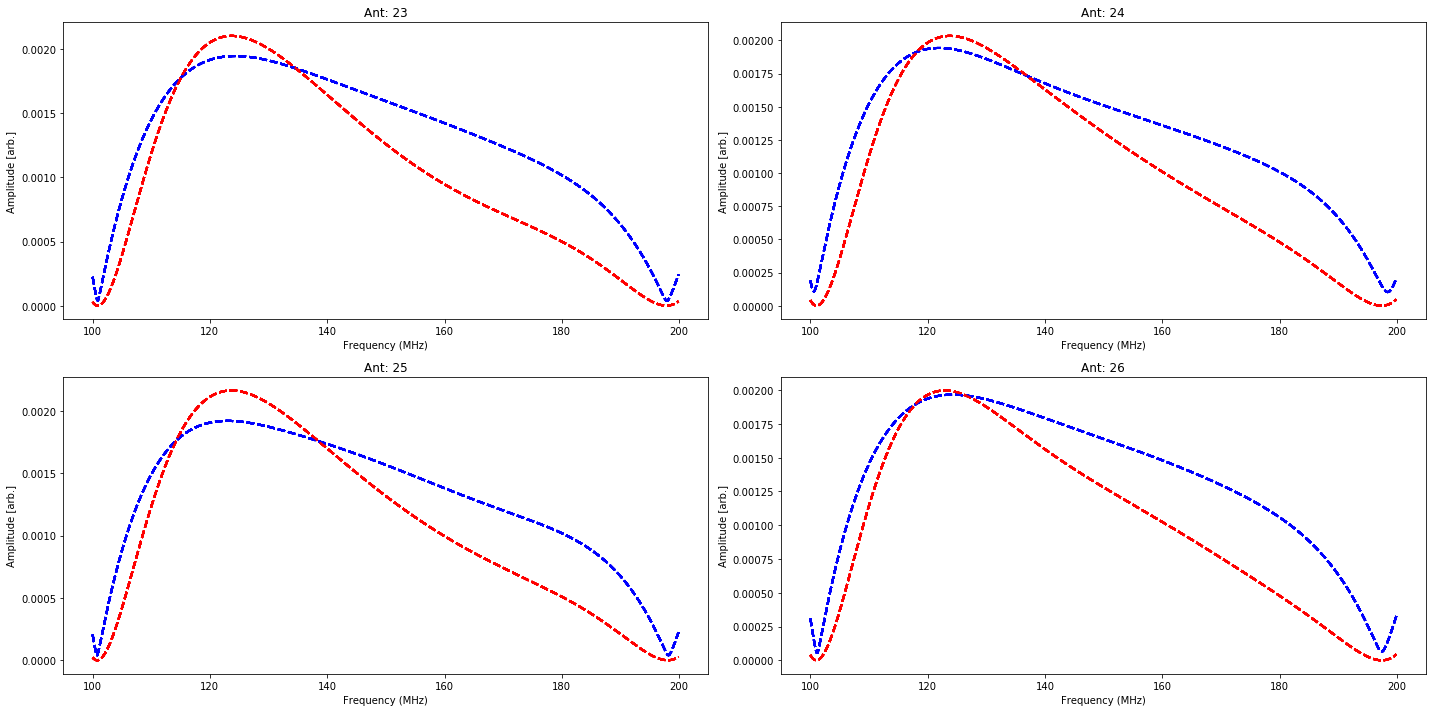

In [51]:
combine_data = np.abs(comb_phase)/700

fig, ax = plt.subplots(2,2, figsize=(20,10))
for ant in ants[::4]:
    ax[0,0].set_ylabel('Amplitude [arb.]')
    ax[0,0].set_xlabel('Frequency (MHz)')
    ax[0,0].set_title('Ant: 23')
    ax[0,0].plot(casafreqs/1e6,combine_data[0,:,int(23)],'b--',label='CASA Gain Solutions',lw=2)
    ax[0,0].plot(casafreqs/1e6,np.abs(np.mean(rmantphs_true_gains[ants[22]], axis=0)),
                'r--',label='Generated Gains',lw=2)
    
    ax[0,1].set_ylabel('Amplitude [arb.]')
    ax[0,1].set_xlabel('Frequency (MHz)')
    ax[0,1].set_title('Ant: 24')
    ax[0,1].plot(casafreqs/1e6,combine_data[0,:,int(24)],'b--',label='CASA Gain Solutions',lw=2)
    ax[0,1].plot(casafreqs/1e6,np.abs(np.mean(rmantphs_true_gains[ants[23]], axis=0)),
                'r--',label='Generated Gains',lw=2)
    
    ax[1,0].set_ylabel('Amplitude [arb.]')
    ax[1,0].set_xlabel('Frequency (MHz)')
    ax[1,0].set_title('Ant: 25')
    ax[1,0].plot(casafreqs/1e6,combine_data[0,:,int(25)],'b--',label='CASA Gain Solutions',lw=2)
    ax[1,0].plot(casafreqs/1e6,np.abs(np.mean(rmantphs_true_gains[ants[24]], axis=0)),
                'r--',label='Generated Gains',lw=2)
    
    ax[1,1].set_ylabel('Amplitude [arb.]')
    ax[1,1].set_xlabel('Frequency (MHz)')
    ax[1,1].set_title('Ant: 26')
    ax[1,1].plot(casafreqs/1e6,combine_data[0,:,int(26)],'b--',label='CASA Gain Solutions',lw=2)
    ax[1,1].plot(casafreqs/1e6,np.abs(np.mean(rmantphs_true_gains[ants[25]], axis=0)),
                'r--',label='Generated Gains',lw=2)
plt.tight_layout()   

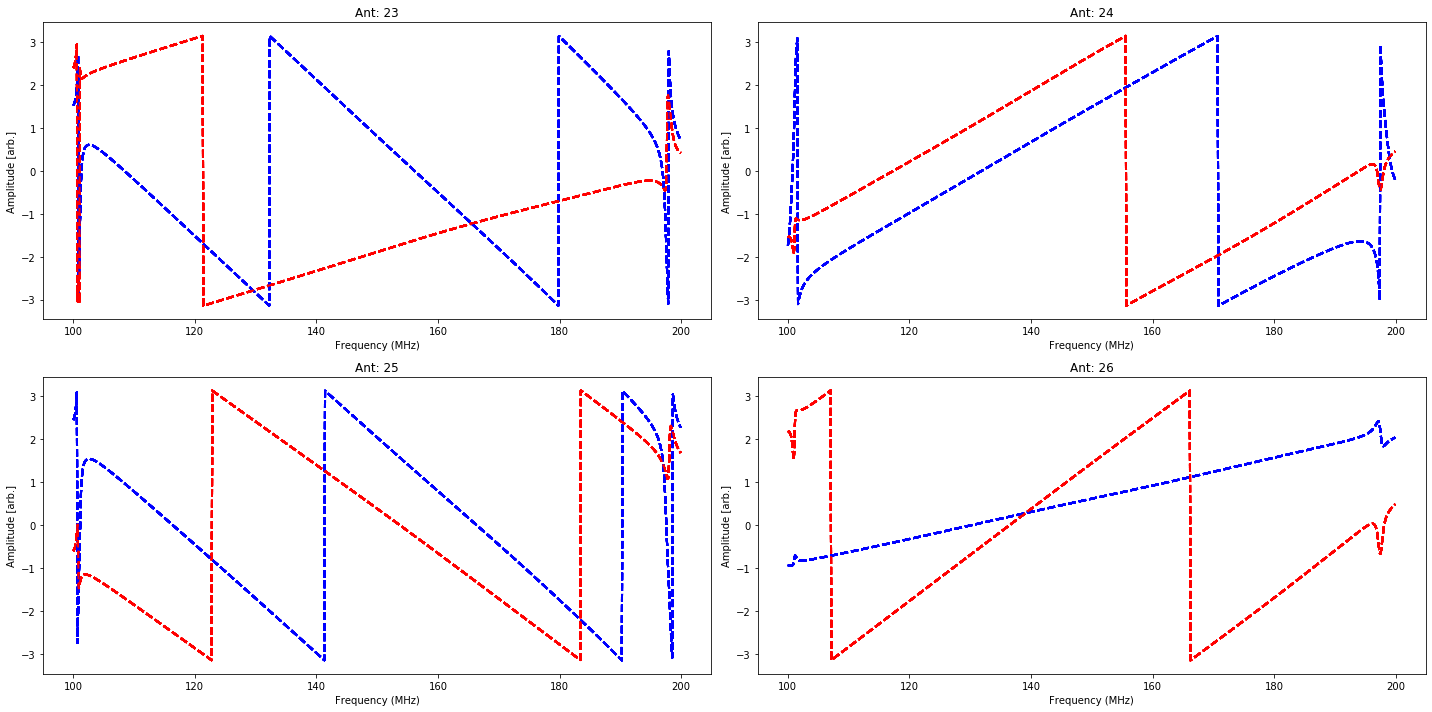

In [43]:
combine_data = np.angle(comb_phase, deg=False)

fig, ax = plt.subplots(2,2, figsize=(20,10))
for ant in ants[::4]:
    ax[0,0].set_ylabel('Amplitude [arb.]')
    ax[0,0].set_xlabel('Frequency (MHz)')
    ax[0,0].set_title('Ant: 23')
    ax[0,0].plot(casafreqs/1e6,combine_data[0,:,int(23)],'b--',label='CASA Gain Solutions',lw=2)
    ax[0,0].plot(casafreqs/1e6,np.angle(np.mean(rmantphs_true_gains[ants[22]], axis=0),deg=False),
                'r--',label='Generated Gains',lw=2)
    
    ax[0,1].set_ylabel('Amplitude [arb.]')
    ax[0,1].set_xlabel('Frequency (MHz)')
    ax[0,1].set_title('Ant: 24')
    ax[0,1].plot(casafreqs/1e6,combine_data[0,:,int(24)],'b--',label='CASA Gain Solutions',lw=2)
    ax[0,1].plot(casafreqs/1e6,np.angle(np.mean(rmantphs_true_gains[ants[23]], axis=0),deg=False),
                'r--',label='Generated Gains',lw=2)
    
    ax[1,0].set_ylabel('Amplitude [arb.]')
    ax[1,0].set_xlabel('Frequency (MHz)')
    ax[1,0].set_title('Ant: 25')
    ax[1,0].plot(casafreqs/1e6,combine_data[0,:,int(25)],'b--',label='CASA Gain Solutions',lw=2)
    ax[1,0].plot(casafreqs/1e6,np.angle(np.mean(rmantphs_true_gains[ants[24]], axis=0),deg=False),
                'r--',label='Generated Gains',lw=2)
    
    ax[1,1].set_ylabel('Amplitude [arb.]')
    ax[1,1].set_xlabel('Frequency (MHz)')
    ax[1,1].set_title('Ant: 26')
    ax[1,1].plot(casafreqs/1e6,combine_data[0,:,int(26)],'b--',label='CASA Gain Solutions',lw=2)
    ax[1,1].plot(casafreqs/1e6,np.angle(np.mean(rmantphs_true_gains[ants[25]], axis=0),deg=False),
                'r--',label='Generated Gains',lw=2)
plt.tight_layout()   